# BaseImageAugmentationLayer를 사용한 커스텀 이미지 보강

**저자:** [lukewood](https://twitter.com/luke_wood_ml)  
**생성일:** 2022/04/26  
**최종편집일:** 2023/11/29  
**설명:** BaseImageAugmentationLayer를 사용하여, 커스텀 데이터 보강을 구현합니다.

In [1]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

In [3]:
from keras import backend

print(backend.backend())

tensorflow


In [4]:
import keras

print(keras.__version__)

3.4.1


## 개요

데이터 보강은 강력한 컴퓨터 비전 모델을 트레이닝하는 데 필수적인 부분입니다.
KerasCV는 다양한 사전 빌드된 고품질 데이터 보강 기술을 제공하지만,
여전히 커스텀 기술을 구현하고 싶을 수 있습니다.
KerasCV는 데이터 보강 레이어를 작성하는 데 유용한 기본 클래스인,
`BaseImageAugmentationLayer`를 제공합니다.
`BaseImageAugmentationLayer`로 빌드된 모든 보강 레이어는,
자동으로 KerasCV `RandomAugmentationPipeline` 클래스와 호환됩니다.

이 가이드에서는 `BaseImageAugmentationLayer`를 사용하여,
커스텀 보강 레이어를 구현하는 방법을 보여줍니다.
예를 들어 모든 이미지를 파란색으로 칠하는(tints) 레이어를 구현합니다.

현재, KerasCV의 전처리 레이어는 Keras 3이 있는 TensorFlow 백엔드만 지원합니다.

In [5]:
# 이 노트북은 Keras cv가 설치되어 있다는 가정 하에 진행됩니다.
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install -q --upgrade keras-cv
# !pip install -q --upgrade keras  # Upgrade to Keras 3.

In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import ops
from keras import layers
import keras_cv
import matplotlib.pyplot as plt

먼저, 시각화와 몇 가지 변환을 위한 몇 가지 도우미 함수를 구현해 보겠습니다.

In [7]:
def imshow(img):
    img = img.astype(int)
    plt.axis("off")
    plt.imshow(img)
    plt.show()


def gallery_show(images):
    images = images.astype(int)
    for i in range(9):
        image = images[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.astype("uint8"))
        plt.axis("off")
    plt.show()


def transform_value_range(images, original_range, target_range):
    images = (images - original_range[0]) / (original_range[1] - original_range[0])
    scale_factor = target_range[1] - target_range[0]
    return (images * scale_factor) + target_range[0]


def parse_factor(param, min_value=0.0, max_value=1.0, seed=None):
    if isinstance(param, keras_cv.core.FactorSampler):
        return param
    if isinstance(param, float) or isinstance(param, int):
        param = (min_value, param)
    if param[0] == param[1]:
        return keras_cv.core.ConstantFactorSampler(param[0])
    return keras_cv.core.UniformFactorSampler(param[0], param[1], seed=seed)

## BaseImageAugmentationLayer 소개

이미지 보강은 배치 단위가 아닌 샘플 단위로 작동해야 합니다.
이는 많은 머신 러닝 실무자가 커스텀 기술을 구현할 때 저지르는 일반적인 실수입니다.
`BaseImageAugmentation`은 이미지 보강 기술을 샘플 단위로 구현하는 것을 훨씬 더 쉽게 만드는,
일련의 깔끔한 추상화를 제공합니다.
이는 최종 사용자가 `augment_image()` 메서드를 재정의한 다음,
후드 아래에서(under the hood) 자동 벡터화를 수행하여 수행됩니다.

대부분의 보강 기술은 또한 하나 이상의 랜덤 분포에서 샘플링해야 합니다.
KerasCV는 랜덤 샘플링을 최종 사용자가 구성할 수 있도록 하는 추상화인,
`FactorSampler` API를 제공합니다.

마지막으로, 많은 보강 기술에는 입력 이미지에 있는 픽셀 값에 대한 정보가 필요합니다.
KerasCV는 이를 처리하는 것을 단순화하기 위해, `value_range` API를 제공합니다.

이 예에서는, `FactorSampler` API, `value_range` API, `BaseImageAugmentationLayer`를 사용하여,
견고하고 구성 가능하며 올바른 `RandomBlueTint` 레이어를 구현합니다.

## `augment_image()` 오버라이드

최소한의 것부터 시작합시다:

In [8]:
class RandomBlueTint(keras_cv.layers.BaseImageAugmentationLayer):
    def augment_image(self, image, *args, transformation=None, **kwargs):
        # 이미지는 (height, width, channels)의 모양을 가지고 있습니다.
        [*others, blue] = ops.unstack(image, axis=-1)
        blue = ops.clip(blue + 100, 0.0, 255.0)
        return ops.stack([*others, blue], axis=-1)

레이어는 `BaseImageAugmentationLayer.augment_image()`를 오버라이드합니다.
이 메서드는 레이어에 제공된 이미지를 보강하는데 사용됩니다.
기본적으로, `BaseImageAugmentationLayer`를 사용하면 몇 가지 멋진 기능을 무료로 사용할 수 있습니다.

* 배치되지 않은(unbatched) 입력 지원(HWC Tensor)
* 배치된(batched) 입력 지원(BHWC Tensor)
* 배치된(batched) 입력에 대한 자동 벡터화(자동 벡터화 성능에서 이에 대한 자세한 정보)

결과를 확인해 보겠습니다. 먼저 샘플 이미지를 다운로드해 보겠습니다.

4217496/4217496 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


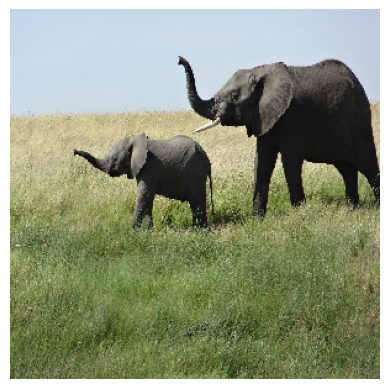

In [9]:
SIZE = (300, 300)
elephants = keras.utils.get_file(
    # "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
    "african_elephant.jpg", "https://github.com/tenkeyless/keras-io_test/blob/main/assets/Bvro0YD.png?raw=true"
)
elephants = keras.utils.load_img(elephants, target_size=SIZE)
elephants = keras.utils.img_to_array(elephants)
imshow(elephants)

다음으로, 이를 보강하여 결과를 시각화해 보겠습니다.

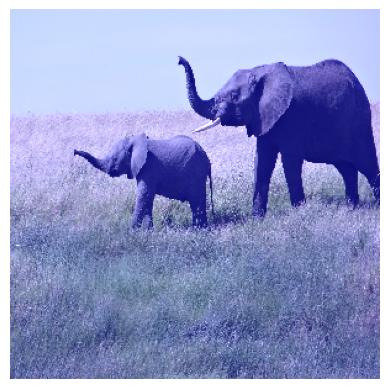

In [10]:
layer = RandomBlueTint()
augmented = layer(elephants)
imshow(ops.convert_to_numpy(augmented))

멋지네요! 배치된 입력에 대한 레이어를 호출할 수도 있습니다.

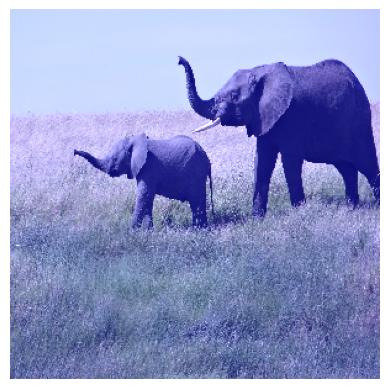

In [11]:
layer = RandomBlueTint()
augmented = layer(ops.expand_dims(elephants, axis=0))
imshow(ops.convert_to_numpy(augmented)[0])

## `FactorSampler` API를 사용하여 랜덤 동작 추가

일반적으로 이미지 보강 기술은,
레이어의 `__call__` 메서드를 호출할 때마다 동일한 작업을 수행해서는 안 됩니다.
KerasCV는 사용자가 구성 가능한 랜덤 분포를 제공할 수 있도록,
`FactorSampler` API를 제공합니다.

In [12]:
class RandomBlueTint(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint는 이미지에 랜덤으로 파란색 색조를 적용합니다.

    Args:
      factor: 두 개의 float 튜플, 단일 float 또는 `keras_cv.FactorSampler`.
        `factor`는 이미지가 파란색으로 이동하는(blue shifted) 정도를 제어합니다.
        `factor=0.0`은 이 레이어가 no-op 연산을 수행하게 하고,
        값 1.0은 퇴화된 결과(degenerated result)를 완전히 사용합니다.
        0과 1 사이의 값은 원본 이미지와 완전히 파란색 이미지 사이에 선형 보간을 수행합니다.
        값은 `0.0`과 `1.0` 사이여야 합니다.
        튜플을 사용하는 경우, `factor`는 보강된 모든 이미지에 대해 두 값 사이에서 샘플링됩니다.
        단일 float를 사용하는 경우, `0.0`과 전달된 float 사이의 값이 샘플링됩니다.
        값이 항상 동일하도록 하려면, 두 개의 동일한 float가 있는 튜플 `(0.5, 0.5)`를 전달하세요.
    """

    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = parse_factor(factor)

    def augment_image(self, image, *args, transformation=None, **kwargs):
        [*others, blue] = ops.unstack(image, axis=-1)
        blue_shift = self.factor() * 255
        blue = ops.clip(blue + blue_shift, 0.0, 255.0)
        return ops.stack([*others, blue], axis=-1)

이제, 우리는 RandomBlueTint 레이어의 랜덤 동작을 구성할 수 있습니다.
우리는 샘플링할 값 범위를 제공할 수 있습니다:

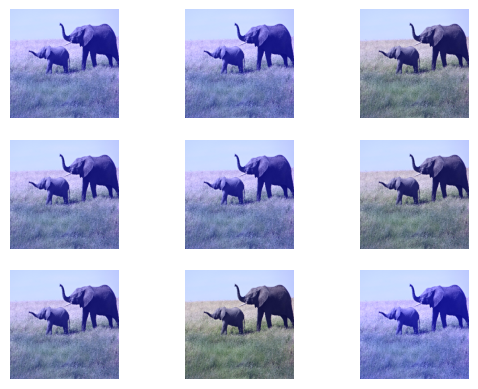

In [13]:
many_elephants = ops.repeat(ops.expand_dims(elephants, axis=0), 9, axis=0)
layer = RandomBlueTint(factor=0.5)
augmented = layer(many_elephants)
gallery_show(ops.convert_to_numpy(augmented))

각 이미지는 `(0, 0.5)` 범위에서, 샘플링된 랜덤 인자로 다르게 보강됩니다.

정규 분포에서 그리도록 레이어를 구성할 수도 있습니다.

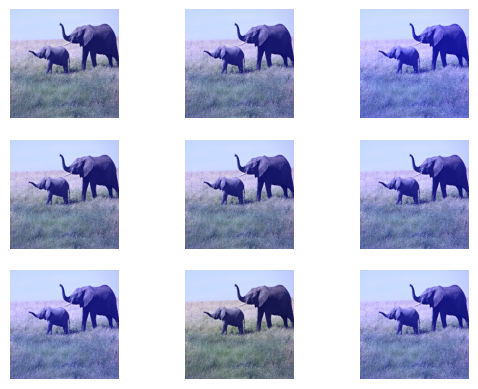

In [14]:
many_elephants = ops.repeat(ops.expand_dims(elephants, axis=0), 9, axis=0)
factor = keras_cv.core.NormalFactorSampler(
    mean=0.3, stddev=0.1, min_value=0.0, max_value=1.0
)
layer = RandomBlueTint(factor=factor)
augmented = layer(many_elephants)
gallery_show(ops.convert_to_numpy(augmented))

보시다시피, 보강은 이제 정규 분포에서 추출되었습니다.
`UniformFactorSampler`, `NormalFactorSampler`, `ConstantFactorSampler`를 포함한,
다양한 타입의 `FactorSampler`가 있습니다. 직접 구현할 수도 있습니다.

## `get_random_transformation()` 오버라이드

이제, 레이어가 예측 대상에 영향을 미친다고 가정해 보겠습니다.
경계 상자, 분류 레이블 또는 회귀 대상인지 여부입니다.
레이어에는 레이블을 보강할 때, 이미지에서 어떤 보강이 수행되는지에 대한 정보가 있어야 합니다.
다행히도, `BaseImageAugmentationLayer`는 이를 염두에 두고 설계되었습니다.

이 문제를 처리하기 위해, `BaseImageAugmentationLayer`에는
`augment_label()`, `augment_target()` 및 `augment_bounding_boxes()`와 함께,
재정의 가능한 `get_random_transformation()` 메서드가 있습니다.
`augment_segmentation_map()` 및 기타 메서드는 나중에 추가됩니다.

이것을 레이어에 추가해 보겠습니다.

In [15]:
class RandomBlueTint(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint는 이미지에 랜덤으로 파란색 색조를 적용합니다.

    Args:
      factor: 두 개의 float 튜플, 단일 float 또는 `keras_cv.FactorSampler`.
        `factor`는 이미지가 파란색으로 이동하는(blue shifted) 정도를 제어합니다.
        `factor=0.0`은 이 레이어가 no-op 연산을 수행하게 하고,
        값 1.0은 퇴화된 결과(degenerated result)를 완전히 사용합니다.
        0과 1 사이의 값은 원본 이미지와 완전히 파란색 이미지 사이에 선형 보간을 수행합니다.
        값은 `0.0`과 `1.0` 사이여야 합니다.
        튜플을 사용하는 경우, `factor`는 보강된 모든 이미지에 대해 두 값 사이에서 샘플링됩니다.
        단일 float를 사용하는 경우, `0.0`과 전달된 float 사이의 값이 샘플링됩니다.
        값이 항상 동일하도록 하려면, 두 개의 동일한 float가 있는 튜플 `(0.5, 0.5)`를 전달하세요.
    """

    def __init__(self, factor, **kwargs):
        super().__init__(**kwargs)
        self.factor = parse_factor(factor)

    def get_random_transformation(self, **kwargs):
        # kwargs는 {"images": 이미지, "labels": 라벨 등}을 보유합니다.
        return self.factor() * 255

    def augment_image(self, image, transformation=None, **kwargs):
        [*others, blue] = ops.unstack(image, axis=-1)
        blue = ops.clip(blue + transformation, 0.0, 255.0)
        return ops.stack([*others, blue], axis=-1)

    def augment_label(self, label, transformation=None, **kwargs):
        # 원한다면 어떻게든 변형을 사용할 수 있습니다

        if transformation > 100:
            # 즉, 클래스 2는 파란색 이미지에 해당할 수 있습니다.
            return 2.0

        return label

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # 파이프라인에서 레이블 타입을 지원하기 위해, no-op 보강을 수행할 수도 있습니다.
        return bounding_boxes

이러한 새로운 메서드를 사용하려면,
이미지에서 타겟으로의 매핑을 유지하는 딕셔너리를 사용하여 입력을 공급해야 합니다.

현재 KerasCV는 다음 레이블 타입을 지원합니다.

* `augment_label()`를 통한 labels.
* `augment_bounding_boxes()`를 통한 bounding\_boxes.

예측 타겟과 함께 보강 레이어를 사용하려면, 다음과 같이 입력을 패키징해야 합니다.

In [16]:
labels = ops.array([[1, 0]])
inputs = {"images": ops.convert_to_tensor(elephants), "labels": labels}

이제 입력에 대한 레이어를 호출하면 다음과 같습니다.

In [17]:
layer = RandomBlueTint(factor=(0.6, 0.6))
augmented = layer(inputs)
print(augmented["labels"])

2.0


입력과 레이블이 모두 보강됩니다.
`transformation`이 > 100일 때,
레이블이 위의 레이어에서 지정된 대로 2.0을 포함하도록 수정되는 방식에 유의하세요.

## `value_range` 지원

여러 파이프라인에서 새로운 보강 레이어를 사용하고 있다고 상상해 보세요.
일부 파이프라인은 `[0, 255]` 범위의 값을 가지고 있고,
일부 파이프라인은 이미지를 `[-1, 1]` 범위로 정규화했으며,
일부는 `[0, 1]`의 값 범위를 사용합니다.

사용자가 값 범위 `[0, 1]`의 이미지로 레이어를 호출하면, 출력이 말도 안 됩니다!

min and max before augmentation: 0.0 1.0
min and max after augmentation: 0.0 26.488235


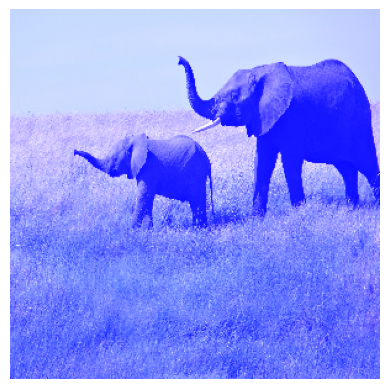

In [18]:
layer = RandomBlueTint(factor=(0.1, 0.1))
elephants_0_1 = elephants / 255
print("min and max before augmentation:", elephants_0_1.min(), elephants_0_1.max())
augmented = layer(elephants_0_1)
print(
    "min and max after augmentation:",
    ops.convert_to_numpy(augmented).min(),
    ops.convert_to_numpy(augmented).max(),
)
imshow(ops.convert_to_numpy(augmented * 255).astype(int))

이것은 매우 약한 보강이라는 점에 유의하세요! Factor는 0.1로만 설정됩니다.

KerasCV의 `value_range` API로 이 문제를 해결해 보겠습니다.

min and max before augmentation: 0.0 1.0
min and max after augmentation: 0.0 1.0


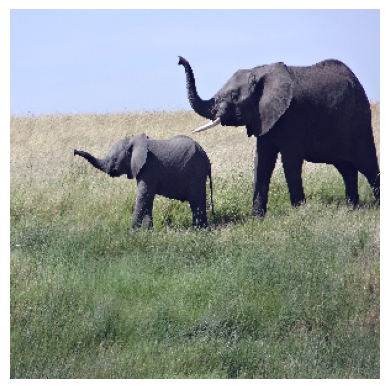

In [19]:
class RandomBlueTint(keras_cv.layers.BaseImageAugmentationLayer):
    """RandomBlueTint는 이미지에 랜덤으로 파란색 색조를 적용합니다.

    Args:
      value_range: 튜플 또는 두 요소의 리스트.
        첫 번째 값은 전달된 이미지의 값에 대한 하한을 나타내고, 두 번째 값은 상한을 나타냅니다.
        레이어에 전달된 이미지는 `value_range` 내의 값을 가져야 합니다.
      factor:두 개의 float 튜플, 단일 float 또는 `keras_cv.FactorSampler`.
        `factor`는 이미지가 파란색으로 이동하는(blue shifted) 정도를 제어합니다.
        `factor=0.0`은 이 레이어가 no-op 연산을 수행하게 하고,
        값 1.0은 퇴화된 결과(degenerated result)를 완전히 사용합니다.
        0과 1 사이의 값은 원본 이미지와 완전히 파란색 이미지 사이에 선형 보간을 수행합니다.
        값은 `0.0`과 `1.0` 사이여야 합니다.
        튜플을 사용하는 경우, `factor`는 보강된 모든 이미지에 대해 두 값 사이에서 샘플링됩니다.
        단일 float를 사용하는 경우, `0.0`과 전달된 float 사이의 값이 샘플링됩니다.
        값이 항상 동일하도록 하려면, 두 개의 동일한 float가 있는 튜플 `(0.5, 0.5)`를 전달하세요.
    """

    def __init__(self, value_range, factor, **kwargs):
        super().__init__(**kwargs)
        self.value_range = value_range
        self.factor = parse_factor(factor)

    def get_random_transformation(self, **kwargs):
        # kwargs는 {"images": 이미지, "labels": 라벨 등}을 보유합니다.
        return self.factor() * 255

    def augment_image(self, image, transformation=None, **kwargs):
        image = transform_value_range(image, self.value_range, (0, 255))
        [*others, blue] = ops.unstack(image, axis=-1)
        blue = ops.clip(blue + transformation, 0.0, 255.0)
        result = ops.stack([*others, blue], axis=-1)
        result = transform_value_range(result, (0, 255), self.value_range)
        return result

    def augment_label(self, label, transformation=None, **kwargs):
        # 원한다면 어떻게든 변형을 사용할 수 있습니다

        if transformation > 100:
            # 즉, 클래스 2는 파란색 이미지에 해당할 수 있습니다.
            return 2.0

        return label

    def augment_bounding_boxes(self, bounding_boxes, transformation=None, **kwargs):
        # 파이프라인에서 레이블 타입을 지원하기 위해, no-op 보강을 수행할 수도 있습니다.
        return bounding_boxes


layer = RandomBlueTint(value_range=(0, 1), factor=(0.1, 0.1))
elephants_0_1 = elephants / 255
print("min and max before augmentation:", elephants_0_1.min(), elephants_0_1.max())
augmented = layer(elephants_0_1)
print(
    "min and max after augmentation:",
    ops.convert_to_numpy(augmented).min(),
    ops.convert_to_numpy(augmented).max(),
)
imshow(ops.convert_to_numpy(augmented * 255).astype(int))

이제 코끼리는 약간 푸른빛을 띠고 있습니다.
이것은 `0.1`의 인수를 사용할 때 예상되는 동작입니다. 훌륭합니다!

이제 사용자는 필요한 모든 값 범위를 지원하도록 레이어를 구성할 수 있습니다.
색상 정보와 상호 작용하는 레이어만 값 범위 API를 사용해야 합니다.
`RandomRotation`과 같은 많은 보강 기술은 이것이 필요하지 않습니다.

## 자동 벡터화 성능

만약 당신이 다음의 것이 궁금하다면:

> 샘플 기준으로(sample-wise) 보강을 구현하면 성능에 영향을 미칠까요?

여러분만 그런 것은 아닙니다!

다행히도, 저는 자동 벡터화, 수동 벡터화 및 벡터화되지 않은 구현의 성능에 대한 광범위한 분석을 수행했습니다.
이 벤치마크에서 자동 벡터화, 자동 벡터화 없음 및 수동 벡터화를 사용하여,
RandomCutout 레이어를 구현했습니다.
이 모든 것은 `@tf.function` 주석 내에서 벤치마크되었습니다.
또한 각각 `jit_compile` 인수로 벤치마크되었습니다.

다음 차트는 이 벤치마크의 결과를 보여줍니다.

![Auto Vectorization Performance Chart](https://i.imgur.com/NeNhDoi.png)

_가장 중요한 점은 수동 벡터화와 자동 벡터화의 차이가 미미하다는 것입니다!_

Eager 모드 성능은 크게 다를 것입니다.


## 일반적인 함정

일부 레이어는 자동으로 벡터화할 수 없습니다.
이에 대한 예는 [GridMask](https://tinyurl.com/ffb5zzf7)입니다.

레이어를 호출할 때 오류가 발생하면, 다음을 생성자에 추가해 보세요.

In [20]:
class UnVectorizable(keras_cv.layers.BaseImageAugmentationLayer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 이렇게 하면 BaseImageAugmentationLayer의 자동 벡터화가 비활성화됩니다.
        self.auto_vectorize = False

또한, 전방 호환성(forwards compatibility)을 보장하기 위해 `augment_*` 메서드에 `**kwargs`를 허용해야 합니다.
KerasCV는 향후 추가 레이블 타입을 추가할 예정이며,
`**kwargs` 인수를 포함하지 않으면 보강 레이어가 전방 호환되지 않습니다.

## 결론 및 다음 단계

KerasCV는 자체 데이터 보강 기술을 구현하는 과정을 간소화하는 표준 API 세트를 제공합니다.
여기에는 `BaseImageAugmentationLayer`, `FactorSampler` API 및 `value_range` API가 포함됩니다.

이러한 API를 사용하여 구성 가능성이 높은 `RandomBlueTint` 레이어를 구현했습니다.
이 레이어는 독립 실행형 이미지, `"images"` 키와 레이블이 있는 딕셔너리,
배치화되지(unbatched) 않은 입력 또는 배치된(batched) 입력으로 입력을 받을 수 있습니다.
입력은 모든 값 범위에 있을 수 있으며,
색조(tint) 값을 샘플링하는 데 사용되는 랜덤 분포는 최종 사용자가 구성할 수 있습니다.

후속 연습으로 다음을 수행할 수 있습니다.

* `BaseImageAugmentationLayer`를 사용하여, 자체 데이터 보강 기법 구현
* [KerasCV에 보강 레이어 기여](https://github.com/keras-team/keras-cv)
* [기존 KerasCV 보강 레이어 읽기](https://tinyurl.com/4txy4m3t)